In [22]:
%pip install scikit-learn
%pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 KB 1.8 MB/s eta 0:00:001.8 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

/home/shreya/prophet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_excel('5-year Revenue by Month.xlsx', sheet_name='sales_formatted')

In [3]:
df.tail()

,Date,Sales
55,2022-08-01,-1965084.07
56,2022-09-01,-1305370.77
57,2022-10-01,-1400608.41
58,2022-11-01,-1355489.16
59,2022-12-01,-1473337.89


<Axes: xlabel='Date'>

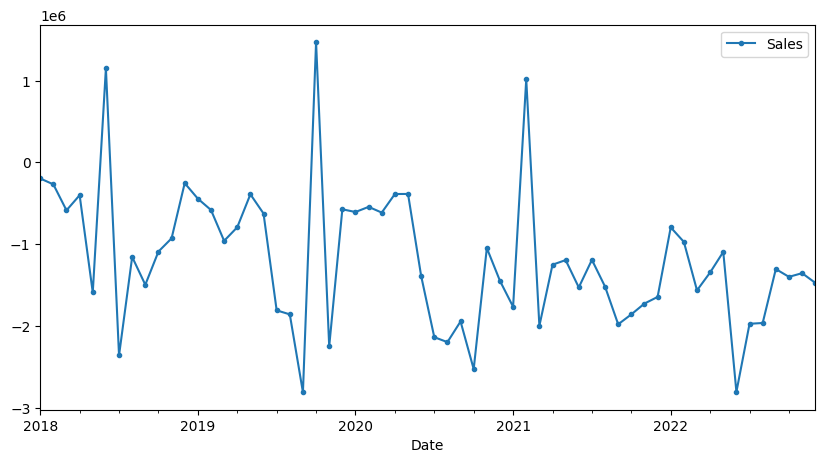

In [4]:
df.plot(x = 'Date', y = 'Sales', style = '.-', figsize = (10,5))

In [5]:
# Resample by month (assuming your data is already sorted by date)
df['month'] = df['Date'].dt.month

df_resampled = df.resample('M', on='Date').first()

# Calculate the date offset (assuming January is month 1)
df_resampled['date_offset'] = (df_resampled['month'] - 1) * 100
df_resampled.head(15)

/tmp/ipykernel_8709/2893181431.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_resampled = df.resample('M', on='Date').first()


,Sales,month,date_offset
Date,,,
2018-01-31,-196865.74,1,0
2018-02-28,-269009.59,2,100
2018-03-31,-586845.59,3,200
2018-04-30,-401754.39,4,300
2018-05-31,-1591076.88,5,400
2018-06-30,1150103.39,6,500
2018-07-31,-2362525.88,7,600
2018-08-31,-1156870.14,8,700
2018-09-30,-1497283.06,9,800


In [6]:
def create_features(df, label = None):
    '''
    Splits the data into features
    '''
    df = df.copy()
    df['date'] = df['Date']
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['date_offset'] = (df['month']) * 100
    df['season'] = pd.cut(df['date_offset'], 
                                 [0, 300, 600, 900, 1200], 
                                 labels=['Spring', 'Summer', 'Fall', 'Winter'])
    X = df[['quarter','month','year','season']]
    if label:
        y = df[label]
        return X, y
    return X
X, y = create_features(df, label='Sales')
features_and_target = pd.concat([X, y], axis=1)

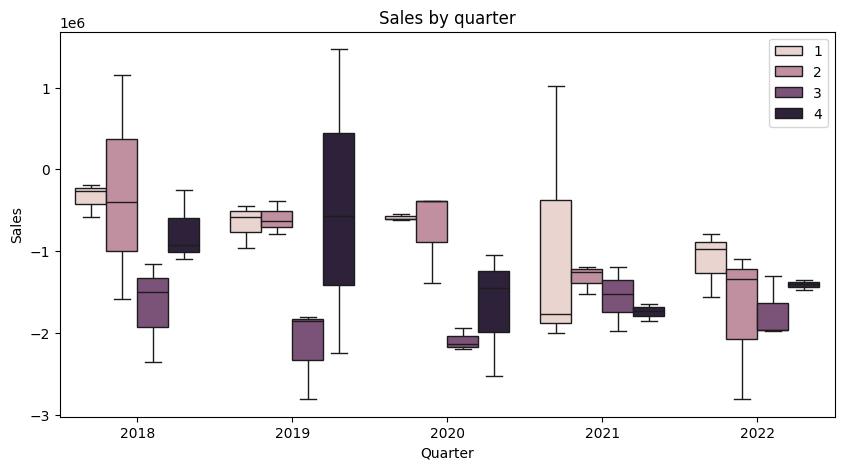

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='year',
            y='Sales',
            hue='quarter',
            ax=ax,
            linewidth=1)
ax.set_title('Sales by quarter')
ax.set_xlabel('Quarter')
ax.set_ylabel('Sales')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

In [8]:
df.rename(columns = {'Date':'ds', 'Sales':'y'}, inplace=True)

In [9]:
train = df[:-12]
test = df[-12:]
print(len(test))

12


In [10]:
m = Prophet()
m.add_country_holidays(country_name = 'India')
m.fit(train)

/home/shreya/prophet/lib/python3.10/site-packages/holidays/countries/india.py:100: Warning: Diwali and Holi holidays available from 2001 to 2030 only
  warnings.warn(warning_msg, Warning)
23:15:05 - cmdstanpy - INFO - Chain [1] start processing
23:15:05 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
m.train_holiday_names

0      Makar Sankranti / Pongal
1                  Republic Day
2              Independence Day
3                Gandhi Jayanti
4                    Labour Day
5                        Diwali
6                          Holi
7     Day of Ashura (estimated)
8            Mawlid (estimated)
9       Eid ul-Fitr (estimated)
10      Eid al-Adha (estimated)
11                  Palm Sunday
12                  Good Friday
13                Easter Sunday
14           Feast of Pentecost
15                Christmas Day
dtype: object

In [12]:
test_fcst = m.predict(test)
print(len(test_fcst))

12


In [13]:
test_fcst

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Day of Ashura (estimated),...,holidays,holidays_lower,holidays_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-01-01,-1.393048e+06,-1.964522e+06,-7.625724e+05,-1.393048e+06,-1.393048e+06,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,3.004290e+04,3.004290e+04,3.004290e+04,0.0,0.0,0.0,-1.363005e+06
1,2022-02-01,-1.409510e+06,-9.869211e+05,2.550164e+05,-1.409510e+06,-1.409510e+06,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,1.064045e+06,1.064045e+06,1.064045e+06,0.0,0.0,0.0,-3.454656e+05
2,2022-03-01,-1.424380e+06,-2.129352e+06,-8.877646e+05,-1.424380e+06,-1.424380e+06,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,-7.057418e+04,-7.057418e+04,-7.057418e+04,0.0,0.0,0.0,-1.494954e+06
3,2022-04-01,-1.440842e+06,-1.780604e+06,-5.539454e+05,-1.440842e+06,-1.440842e+06,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,2.505045e+05,2.505045e+05,2.505045e+05,0.0,0.0,0.0,-1.190338e+06
4,2022-05-01,-1.456774e+06,-1.962552e+06,-7.678040e+05,-1.456774e+06,-1.456774e+06,0.0,0.0,0.0,0.0,...,-4.637259e+06,-4.637259e+06,-4.637259e+06,4.717953e+06,4.717953e+06,4.717953e+06,0.0,0.0,0.0,-1.376080e+06
5,2022-06-01,-1.473236e+06,-1.452539e+06,-2.033887e+05,-1.473236e+06,-1.473236e+06,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,6.337761e+05,6.337761e+05,6.337761e+05,0.0,0.0,0.0,-8.394602e+05
6,2022-07-01,-1.489168e+06,-3.010809e+06,-1.789102e+06,-1.489168e+06,-1.489168e+06,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,-9.169137e+05,-9.169137e+05,-9.169137e+05,0.0,0.0,0.0,-2.406082e+06
7,2022-08-01,-1.505630e+06,-2.666922e+06,-1.423133e+06,-1.505630e+06,-1.505630e+06,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,-5.228607e+05,-5.228607e+05,-5.228607e+05,0.0,0.0,0.0,-2.028491e+06
8,2022-09-01,-1.522093e+06,-3.353696e+06,-2.187194e+06,-1.522093e+06,-1.522093e+06,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,-1.249687e+06,-1.249687e+06,-1.249687e+06,0.0,0.0,0.0,-2.771780e+06
9,2022-10-01,-1.538025e+06,-1.582487e+06,-4.000308e+05,-1.538025e+06,-1.538024e+06,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,5.521030e+05,5.521030e+05,5.521030e+05,0.0,0.0,0.0,-9.859215e+05


/home/shreya/prophet/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/shreya/prophet/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


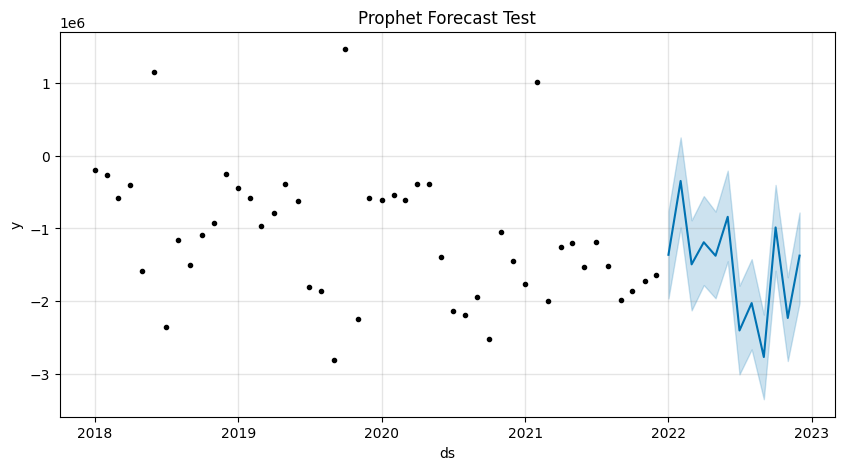

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = m.plot(test_fcst, ax=ax)
ax.set_title('Prophet Forecast Test')

plt.show()

/home/shreya/prophet/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/shreya/prophet/lib/python3.10/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/home/shreya/prophet/lib/python3.10/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the o

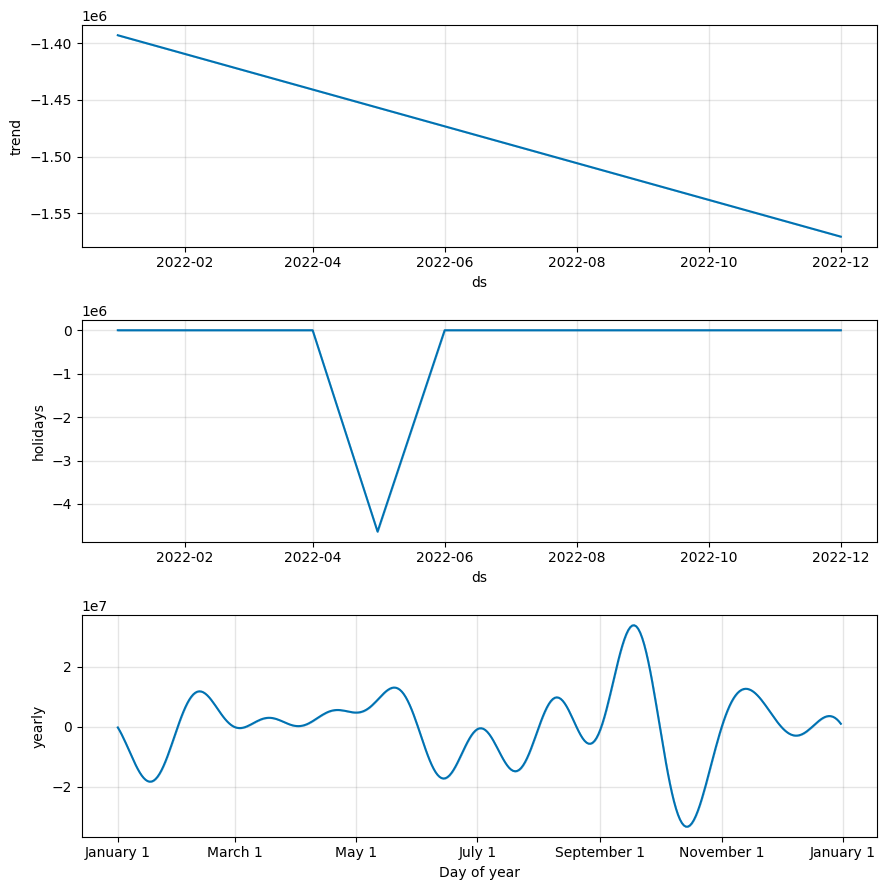

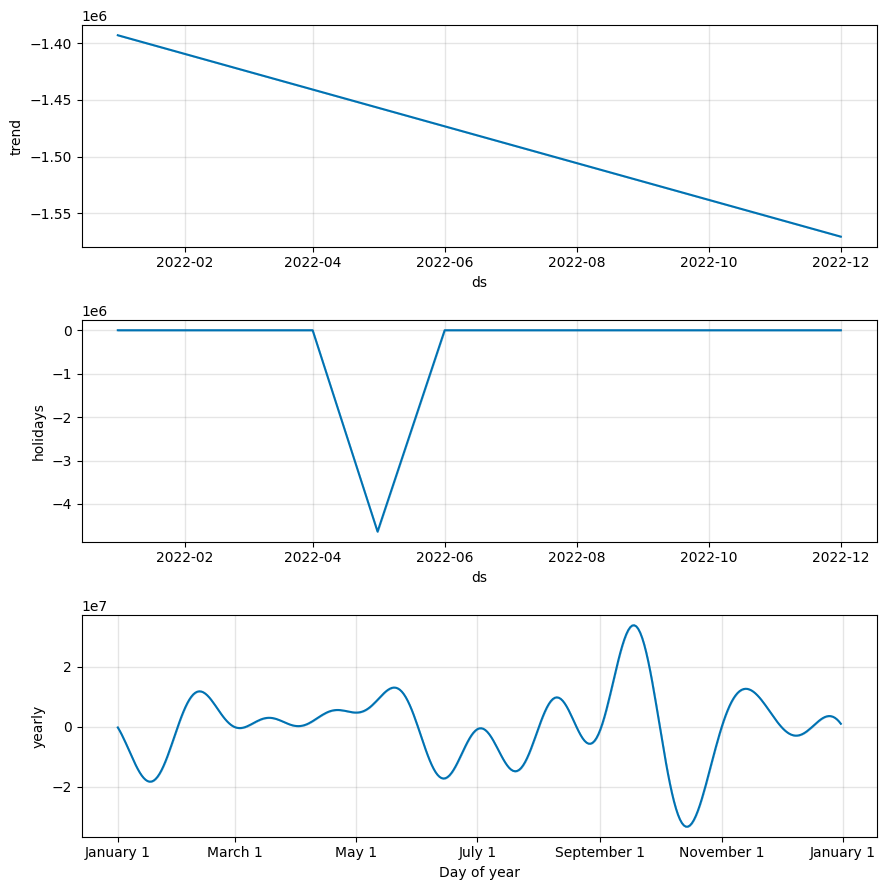

In [15]:
m.plot_components(test_fcst)

/home/shreya/prophet/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/shreya/prophet/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


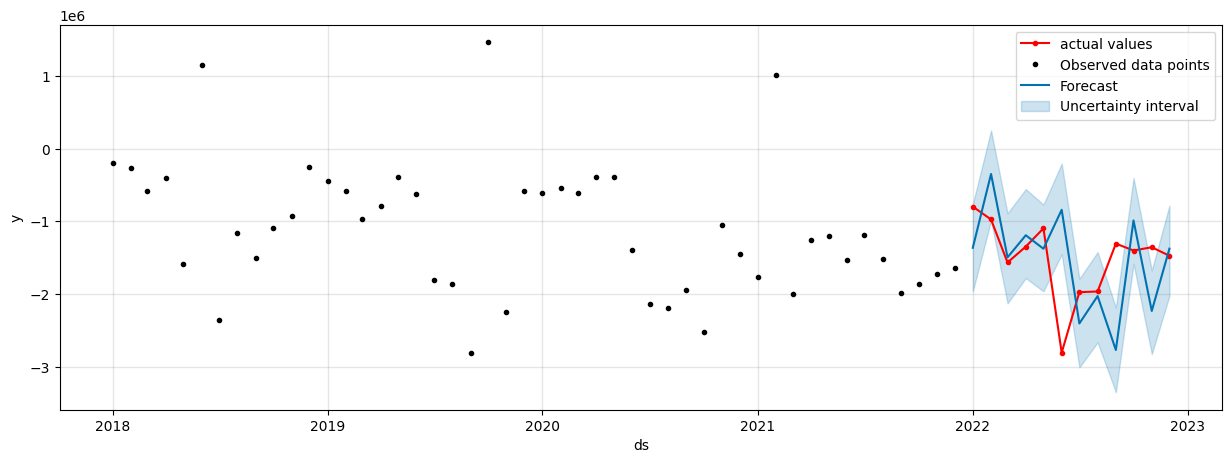

In [16]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.plot(test['ds'], test['y'], color='r', marker = '.', label = 'actual values')
plt.legend()
fig = m.plot(test_fcst, ax=ax, include_legend=True)

In [17]:
mean_absolute_error(y_true=test['y'], y_pred=test_fcst['yhat'])

585384.1882025591

In [18]:
mean_absolute_percentage_error(y_true=test['y'], y_pred=test_fcst['yhat']) * 100

40.522796676136785

In [29]:
import math

math.sqrt(mean_squared_error(y_true=test['y'], y_pred=test_fcst['yhat']))

816180.0102581515

In [22]:
test

,ds,y,month
48,2022-01-01,-795200.62,1
49,2022-02-01,-972733.29,2
50,2022-03-01,-1565651.86,3
51,2022-04-01,-1346805.51,4
52,2022-05-01,-1095199.11,5
53,2022-06-01,-2808288.05,6
54,2022-07-01,-1974909.27,7
55,2022-08-01,-1965084.07,8
56,2022-09-01,-1305370.77,9
57,2022-10-01,-1400608.41,10


In [21]:
future = m.make_future_dataframe(periods=12, freq = 'MS')
future[-12:]

,ds
48,2022-01-01
49,2022-02-01
50,2022-03-01
51,2022-04-01
52,2022-05-01
53,2022-06-01
54,2022-07-01
55,2022-08-01
56,2022-09-01
57,2022-10-01


In [31]:
forecast = m.predict(future)
forecast[['ds', 'yhat']].tail()

,ds,yhat
67,2023-08-01,-2.685163e+06
68,2023-09-01,-3.381641e+06
69,2023-10-01,-1.756570e+05
70,2023-11-01,-2.963521e+06
71,2023-12-01,-1.376342e+06


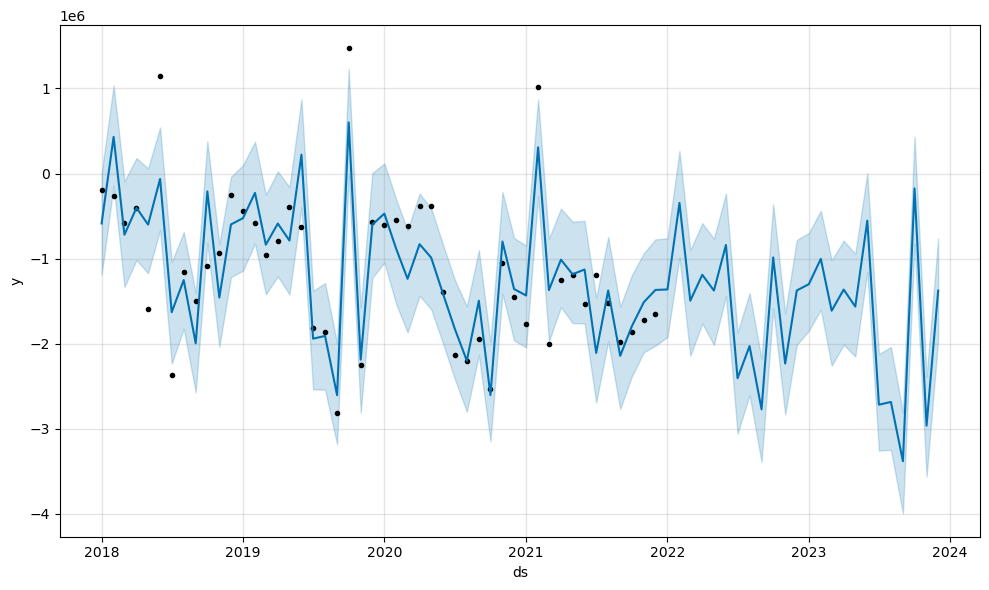

In [32]:
fig1 = m.plot(forecast)

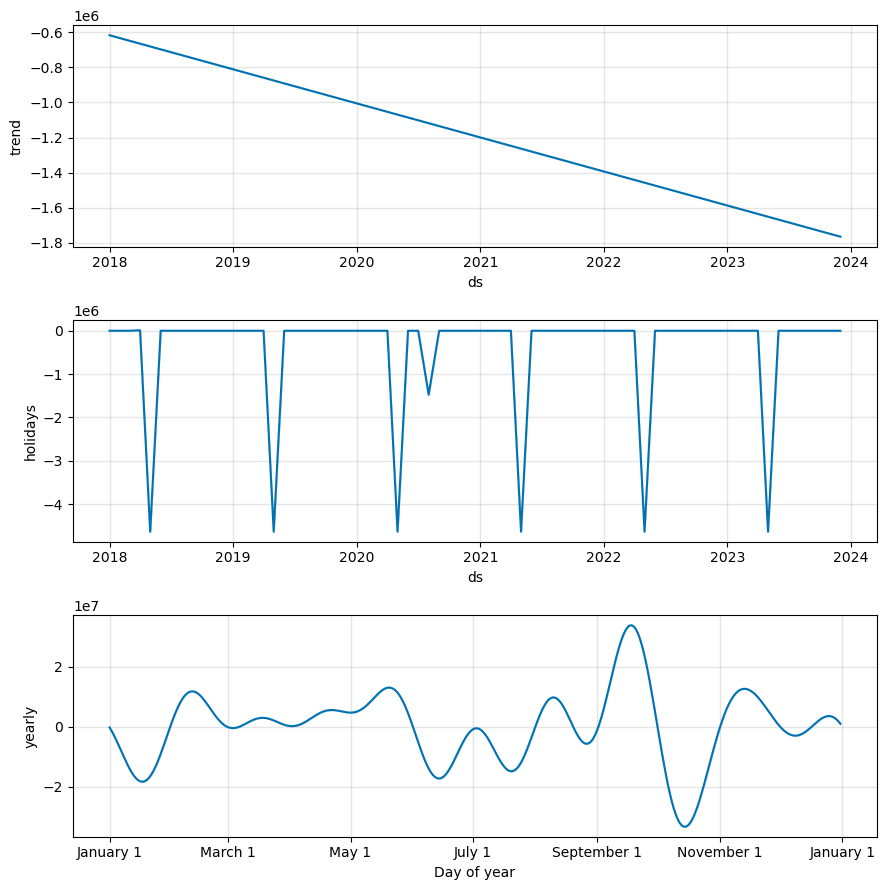

In [33]:
fig = m.plot_components(forecast)

In [40]:
import itertools
import numpy as np
import pandas as pd

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m, initial = '365 days', horizon='30 days', period = '30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

08:43:23 - cmdstanpy - INFO - Chain [1] start processing
08:43:23 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
08:43:23 - cmdstanpy - INFO - Chain [1] start processing
08:43:23 - cmdstanpy - INFO - Chain [1] start processing
08:43:23 - cmdstanpy - INFO - Chain [1] start processing
08:43:23 - cmdstanpy - INFO - Chain [1] start processing
08:43:23 - cmdstanpy - INFO - Chain [1] start processing
08:43:23 - cmdstanpy - INFO - Chain [1] start processing
08:43:23 - cmdstanpy - INFO - Chain [1] start processing
08:43:23 - cmdstanpy - INFO - Chain [1] start processing
08:43:23 - cmdstanpy - INFO - Chain [1] start processing
08:43:23 - cmdstanpy - INFO - Chain [1] start processing
08:43:23 - cmdstanpy - INFO - Chain [1] start processing
08:43:23 - cmdstanpy - INFO - Chain [1] start processing
08:43:24 - cmdstanpy - INFO - Chain [1] done processing
08:43:24 - cmdstanpy - INFO - Chain [1] don

    changepoint_prior_scale  seasonality_prior_scale          rmse
0                     0.001                     0.01  8.504998e+05
1                     0.001                     0.10  9.372217e+05
2                     0.001                     1.00  9.859479e+05
3                     0.001                    10.00  1.530977e+06
4                     0.010                     0.01  8.487142e+05
5                     0.010                     0.10  9.411204e+05
6                     0.010                     1.00  9.520608e+05
7                     0.010                    10.00  1.379764e+06
8                     0.100                     0.01  8.481752e+05
9                     0.100                     0.10  9.431552e+05
10                    0.100                     1.00  9.654867e+05
11                    0.100                    10.00  1.725381e+06
12                    0.500                     0.01  8.480860e+05
13                    0.500                     0.10  9.956206

In [78]:
params_dict = dict(tuning_results.sort_values('rmse').reset_index(drop=True).iloc[0].drop('rmse'))
params_dict

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01}

In [80]:
m = Prophet(changepoint_prior_scale=params_dict['changepoint_prior_scale'], seasonality_prior_scale=params_dict['seasonality_prior_scale'])
m.add_country_holidays('India')
m.fit(df)

/home/shreya/.local/lib/python3.10/site-packages/holidays/countries/india.py:100: Warning: Diwali and Holi holidays available from 2001 to 2030 only
  warnings.warn(warning_msg, Warning)
10:00:50 - cmdstanpy - INFO - Chain [1] start processing
10:00:51 - cmdstanpy - INFO - Chain [1] done processing


In [84]:
future = m.make_future_dataframe(periods=1, freq='MS')

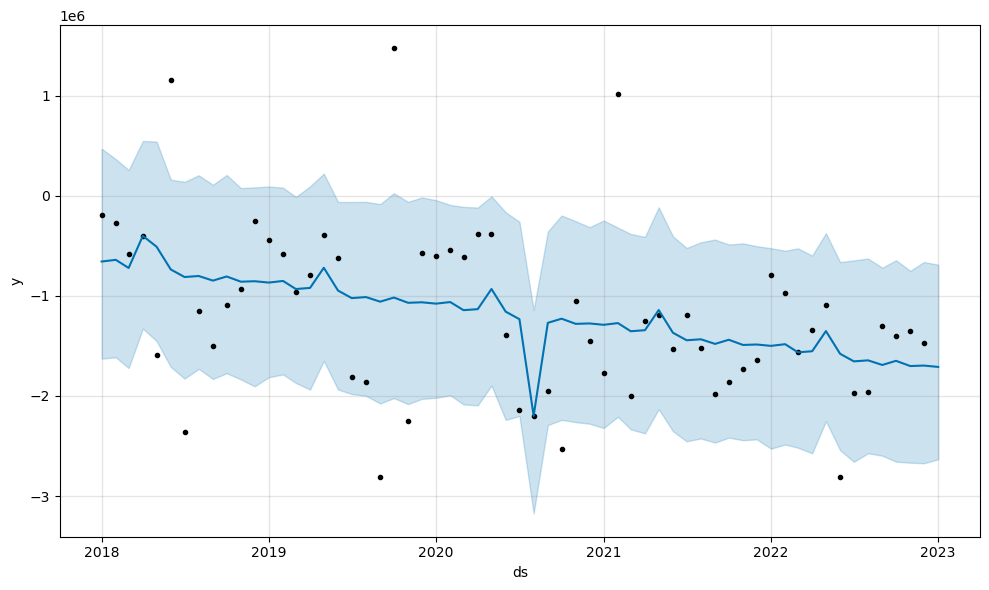

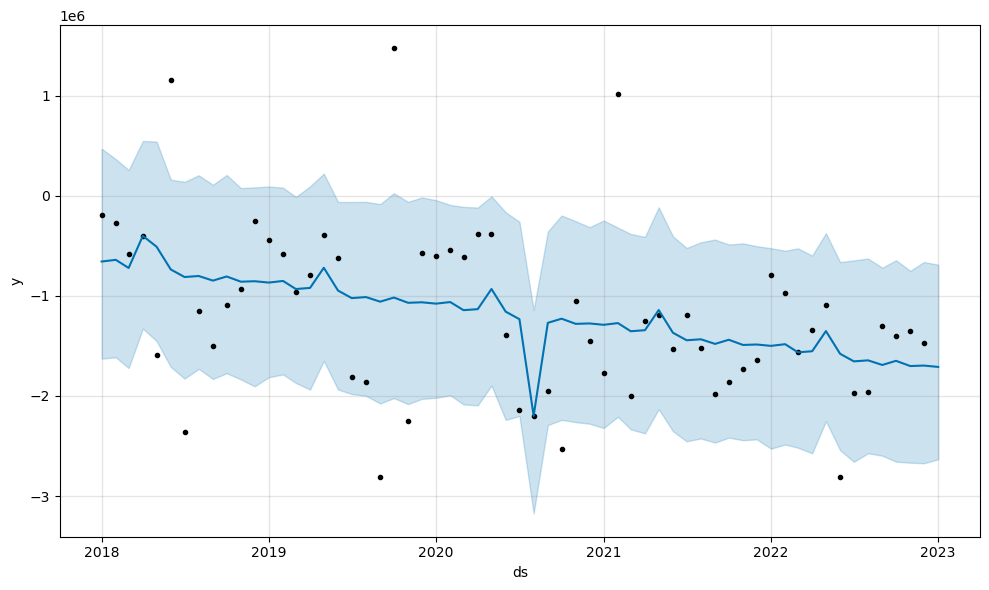

In [85]:
fcst = m.predict(future)
m.plot(fcst)

In [104]:
forecast_start_date = future[-13:].iloc[0]['ds']
filter = fcst['ds']>=forecast_start_date 
predicted_df = fcst[filter][['ds','yhat']]

df_copy = df.copy()
df_copy.drop('month',axis = 1,inplace=True)
df_copy.columns = ['ds', 'ytrue']
predicted_df = predicted_df.merge(df_copy)
mean_absolute_percentage_error(predicted_df['ytrue'], predicted_df['yhat'])

0.2870462280168262

In [ ]:
df_line = pd.read_excel(